# Max Cut problem with VQE

### Problem description

A graph is an object that contains nodes and connections between those nodes. Connections are weighted with specific values. The problem consists in dividing the nodes in two families, such that the divisory lines cross as much weight as possible. So for example, given the following graph, you can try and guess the best cut:
![](maxcut1.png)

The solution is given by the following cut:
![](maxcut2.png)

We can use some physics for describing this problem. We can define some sort of cost function representing a given cut in order to minimize. This cost function is given by $E = \frac{1}{2}(w_s-w_d)$, where $w_s$ are the weight between same color nodes, and $w_d$ between different color nodes. Given $N$ nodes, we can think that each noche might be red or blue, or alternatively 0 or 1. This new notation might wake our intuition up: qubits. The same should happen with our cost function being called $E$: energy. So we can think of this problem as finding the minimum state of N qubits given a hamiltonian. For example, given 3 nodes with certain weight, we could have the following hamiltonian:
![](maxcut3.png)

This is the Max cut problem, which is known to be NP-Complete. A different cost function can be given centered on the nodes instead of the connections: $C = \sum_{ij} w_{ij}x_i(1-x_j)$, where $x_k$ might be 0 or 1 depending on the group at which the node belongs. An extension can be given by considering individual weights: $C = \sum_{ij} w_{ij}x_i(1-x_j) + \sum_i w_i x_i$. This problem might be mapped directly into an Ising Hamiltonian by considering the transformation $x_i\rightarrow (I-Z_i)/2$:

$H = \sum_i x_i Z_i + \sum_{ij}w_{ij}Z_iZ_j$

Now we can perform VQE with this Hamiltonian. For this example, our ansatz will be given by $|\psi(\theta)\rangle = [U_{single}(\theta)U_{entangler}]^M|+\rangle$, with $U_{single}(\theta) = \prod_i^N Y(\theta_i)$ (N is the number of qubits and M the circuit's depth).
These problems can also be treated with annealing, but are limited to the connectivity of the device, which is a strong constraint in the general case.



In [2]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely

import warnings
warnings.filterwarnings('ignore')

In [3]:
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to s

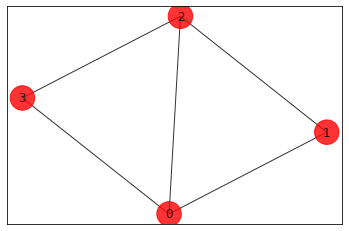

In [4]:
# Generating a graph of 4 nodes 

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [5]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight'] 
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


### Brute Force
Let's first tackle this problem via Brute force, i.e. by trying out all $2^N$ possible configuration. This is not a problem for $N=4$, but scales up pretty quickly.

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


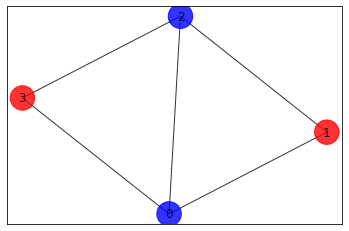

In [6]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))    

### Mapping to Ising


In [7]:
qubitOp, offset = max_cut.get_operator(w)

2020-07-18 19:47:31,482:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-1.5+0.j]),
    'eigvecs': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
    'energies': array([-1.5]),
    'energy': -1.5,
    'wavefunction': array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}
2020-07-18 19:47:31,487:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: EigensolverResult dict:
{   'eigenstates': ListOp([VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2)), coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False),
    'eigenvalues': array([-1.5+0.j])}


energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


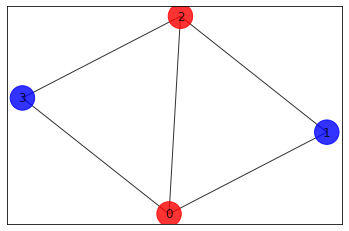

In [8]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

### Run on a Quantum Device
We will use BasicAer to simulate VQE on a quantum computer.

In [ ]:
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

2020-07-18 19:47:40,019:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- include_custom: False
-- expect_op: None
-- operator: SummedOp(
[0.5 * IIZZ,
0.5 * IZIZ,
0.5 * IZZI,
0.5 * ZIIZ,
0.5 * ZZII])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f1b75da4780>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f1b75da4470>>
-- initial_point: Random seed
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x7f1b75d95f98>
-- var_form_params: θ, ['θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]', 'θ[12]', 'θ[13]', 'θ[14]', 'θ[15]', 'θ[16]', 'θ[17]', 'θ[18]', 'θ[19]', 'θ[20]', 'θ[21]', 'θ[22]', 'θ[23]']
-- parameterized_circuits: None
-- ret: None
-- ev

/home/marco/miniconda3/envs/tequila/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  """
2020-07-18 12:28:55,008:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- include_custom: False
-- expect_op: None
-- operator: SummedOp(
[0.5 * IIZZ,
0.5 * IZIZ,
0.5 * IZZI,
0.5 * ZIIZ,
0.5 * ZZII])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f6c7befdf28>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f6c7befdc88>>
-- initial_point: Ra

energy: -1.5
time: 21.63572335243225
max-cut objective: -4.0
solution: [1 0 1 0]
solution objective: 4.0


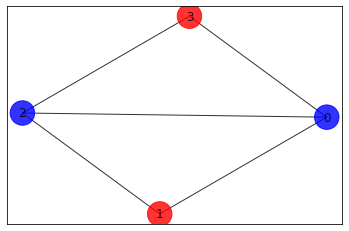

In [9]:
# run quantum algorithm with shots
seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)